In [1]:
"""
Creer le JEUDI 8 Decembre 2022
   - ------   BINANCE and BITGET BACKTEST   -------
      -----------  BACKTEST LIVE DATA and DATA BASE --------
              ( -  - )
YT :::
Crypto Robot
8,28 k abonnés


Créer et Installer votre Premier BOT DE TRADING FUTUR en Python ! 
Tutoriel Facile BITGET. avec la Strategie BOLINGER BAND.
Créer un BOT de trading RENTABLE sur les FUTURES de FTX ? 
Le meilleur trade à +132% !

https://www.youtube.com/watch?v=LO-7OM8X_L8
https://www.youtube.com/watch?v=LO-7OM8X_L8

GitHub :
CryptoRobotFr/backtest_tools...
CryptoRobotFr/backtest_tools...
CryptoRobotFr/backtest_tools...
https://github.com/CryptoRobotFr/backtest_tools/blob/main/backtest/single_coin/bol_trend.ipynb
https://github.com/CryptoRobotFr/backtest_tools/blob/main/backtest/single_coin/bol_trend.ipynb
https://github.com/CryptoRobotFr/backtest_tools/blob/main/backtest/single_coin/bol_trend.ipynb

BOT Files for BITGET :

"""


'\nvendredi 28 Octobre 2022\n   - ------   BINANCE FTX BACKTEST   -------\n      -----------  BACKTEST LIVE DATA and DATA BASE --------\n              ( -  - )\nYT :::\nCrypto Robot\n8,28 k abonnés\n\n\nCréer un BOT de trading RENTABLE sur les FUTURES de FTX ? \nLe meilleur trade à +132% !\n\nhttps://www.youtube.com/watch?v=ZQx00zMI_6w&t=123s\nhttps://www.youtube.com/watch?v=ZQx00zMI_6w&t=123s\n\nGitHub :\nhttps://github.com/CryptoRobotFr/cBot/tree/main/exemples/aligatorPerp\nhttps://github.com/CryptoRobotFr/cBot/tree/main/exemples/aligatorPerp\n\nBOT Files for FTX :\n1.) BOT AligatorPerpLive.py\n2.) cBot_perp_ftx.py\n\n'

In [ ]:
import sys
sys.path.append('../..')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import  ...
from utilities.custom_indicators import get_n_columns
import pandas as pd
pd.options.mode.chained_assignment = None # default ='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np

In [ ]:
class BolTrend():
    def __init__(
        self,
        df,
        type=["long"],
        bol_window = 100,
        bol_std = 2.25,
        min_bol_spread = 0,
        long_ma_window = 500,
    ):
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.bol_window = bol_window
        self.bol_std = bol_std
        self.min_bol_spread = min_bol_spread
        self.long_ma_window = long_ma_window
        
    def populate_indicators(self):
        # -- Clear dataset --
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
        
        # -- Populate indicators --
        bol_band = ta.volatility.BollingerBands(close=df["close"], window=self.bol_window, window_dev=self.bol_std)
        df["lower_band"] = bol_band.bollinger_lband()
        df["higher_band"] = bol_band.bollinger_hband()
        df["ma_band"] = bol_band.bollinger_mavg()

        df['long_ma'] = ta.trend.sma_indicator(close=df['close'], window=self.long_ma_window)

        df = get_n_columns(df, ["ma_band", "lower_band", "higher_band", "close"], 1)
        
        self.df = df    
        return self.df
    
    def populate_buy_sell(self): 
        df = self.df
        # -- Initiate populate --
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False
        
        if self.use_long:
            # -- Populate open long market --
            df.loc[
                (df['n1_close'] < df['n1_higher_band']) 
                & (df['close'] > df['higher_band']) 
                & ((df['n1_higher_band'] - df['n1_lower_band']) / df['n1_lower_band'] > self.min_bol_spread)
                & (df["close"] > df["long_ma"]) 
                , "open_long_market"
            ] = True
        
            # -- Populate close long market --
            df.loc[
                (df['close'] < df['ma_band']) 
                , "close_long_market"
            ] = True

        if self.use_short:
            # -- Populate open short market --
            df.loc[
                (df['n1_close'] > df['n1_lower_band']) 
                & (df['close'] < df['lower_band']) 
                & ((df['n1_higher_band'] - df['n1_lower_band']) / df['n1_lower_band'] > self.min_bol_spread)
s                & (df["close"] < df["long_ma"])
                , "open_short_market"
            ] = True
        
            # -- Populate close short market --
            df.loc[
                (df['close'] > df['ma_band']) 
                , "close_short_market"
            ] = True
        
        self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, leverage=1):
        df = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = ((close_price - current_position['price']) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = ((current_position['price'] - close_price) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # -- Open long Market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        } 

In [ ]:
pair = "BTC/USDT"
tf = "1h"

df = get_historical_from_db(
    ccxt.binance(), 
    pair,
    tf,
    path="../../database/"
)


In [ ]:
strat = BolTrend(
    df = df.loc["2018":],
    type=["long","short"],
    bol_window = 100,
    bol_std = 2.25,
    min_bol_spread = 0,
    long_ma_window = 500,
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)

In [2]:
"""
7 085 vues  17 oct. 2021
Aujourd'hui une vidéo sur les bot de trading. 
On vous apprend à réaliser vos propres bots de trading avec des SHORT, des LONG et des Stop Loss. 
Vous pouvez par la suite implémenter ce programme directement sur FTX.

Lien vers le code présenté dans la vidéo : 
https://github.com/CryptoRobotFr/cBot...



BOT Files for FTX :
1.) BOT AligatorPerpLive.py
2.) cBot_perp_ftx.py

"""

"\n7\u202f085 vues  17 oct. 2021\nAujourd'hui une vidéo sur les bot de trading. \nOn vous apprend à réaliser vos propres bots de trading avec des SHORT, des LONG et des Stop Loss. \nVous pouvez par la suite implémenter ce programme directement sur FTX.\n\nLien vers le code présenté dans la vidéo : \nhttps://github.com/CryptoRobotFr/cBot...\n\n\n\nBOT Files for FTX :\n1.) BOT AligatorPerpLive.py\n2.) cBot_perp_ftx.py\n\n"

In [3]:
pip install python-binance

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load yours data
# -- Import --
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt
import numpy as np

# -- Define Binance Client --
client = Client()

In [6]:
import pandas as pd
df=pd.read_csv("EURUSD_Candlestick_5_M_ASK_30.09.2019-30.09.2022.csv")
df

,Gmt time,Open,High,Low,Close,Volume
0,30.09.2019 00:00:00.000,1.09425,1.09426,1.09405,1.09406,585.10
1,30.09.2019 00:05:00.000,1.09408,1.09414,1.09401,1.09409,289.39
2,30.09.2019 00:10:00.000,1.09410,1.09423,1.09408,1.09410,276.24
3,30.09.2019 00:15:00.000,1.09409,1.09410,1.09388,1.09389,439.29
4,30.09.2019 00:20:00.000,1.09390,1.09395,1.09388,1.09395,341.23
...,...,...,...,...,...,...
225081,30.09.2022 20:35:00.000,0.98028,0.98034,0.98001,0.98022,624.12
225082,30.09.2022 20:40:00.000,0.98023,0.98047,0.98007,0.98030,408.20
225083,30.09.2022 20:45:00.000,0.98026,0.98034,0.98019,0.98031,317.29
225084,30.09.2022 20:50:00.000,0.98031,0.98067,0.97987,0.97999,1472.13


In [7]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [8]:
import yfinance as yf
#df = yf.download(tickers='BTC-USD', period='2y', interval='1h')
#df = yf.download(tickers='EURUSD=X', period='59d', interval='15m')
#df = yf.download(tickers='EURUSD=X', period='2y', interval='1h')
df = yf.download(tickers='USDEUR=X', period='2y', interval='1h')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2020-11-16 00:00:00,0.8440,0.8445,0.8440,0.8444,0.8444,0
2020-11-16 01:00:00,0.8444,0.8444,0.8437,0.8438,0.8438,0
2020-11-16 02:00:00,0.8437,0.8439,0.8436,0.8436,0.8436,0
2020-11-16 03:00:00,0.8436,0.8437,0.8433,0.8435,0.8435,0
2020-11-16 04:00:00,0.8435,0.8436,0.8433,0.8435,0.8435,0
...,...,...,...,...,...,...
2022-11-15 10:00:00,0.9607,0.9617,0.9580,0.9586,0.9586,0
2022-11-15 11:00:00,0.9584,0.9603,0.9581,0.9603,0.9603,0
2022-11-15 12:00:00,0.9599,0.9614,0.9599,0.9605,0.9605,0
2022-11-15 13:00:00,0.9605,0.9618,0.9548,0.9576,0.9576,0


In [9]:

#df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']  # Chaner les noms ...
df.columns = ['open', 'high', 'low', 'close', 'adjclose','volume']  # Chaner les noms ...

In [10]:
df

,open,high,low,close,adjclose,volume
2020-11-16 00:00:00,0.8440,0.8445,0.8440,0.8444,0.8444,0
2020-11-16 01:00:00,0.8444,0.8444,0.8437,0.8438,0.8438,0
2020-11-16 02:00:00,0.8437,0.8439,0.8436,0.8436,0.8436,0
2020-11-16 03:00:00,0.8436,0.8437,0.8433,0.8435,0.8435,0
2020-11-16 04:00:00,0.8435,0.8436,0.8433,0.8435,0.8435,0
...,...,...,...,...,...,...
2022-11-15 10:00:00,0.9607,0.9617,0.9580,0.9586,0.9586,0
2022-11-15 11:00:00,0.9584,0.9603,0.9581,0.9603,0.9603,0
2022-11-15 12:00:00,0.9599,0.9614,0.9599,0.9605,0.9605,0
2022-11-15 13:00:00,0.9605,0.9618,0.9548,0.9576,0.9576,0


In [11]:
# -- Set the date to index --
df = df.set_index(df['timestamp'])
del df['timestamp']
# df.index = pd.to_datetime(df.index, unit='ms')
print("Data loaded 100%")
# -- Uncomment the line below if you want to check your price dataset --
# df

KeyError: 'timestamp'

In [5]:


# -- You can change the crypto pair ,the start date and the time interval below --
# pairName = "AVAXUSDT"
pairName = "ETHUSDT"
# pairName = "BTCUSDT"
# pairName = "BNBUSDT"
# pairName = "ADAUSDT"
startDate = "01 january 2017"
# startDate = "01 january 2014"
#startDate = "01 january 2022"
timeInterval = Client.KLINE_INTERVAL_1HOUR
endDate = "01 january 2021"

# -- Load all price data from binance API --
# klinesT = client.get_historical_klines(pairName, timeInterval, startDate)

# -- Load all price data from binance API --
klinesT = client.get_historical_klines(pairName, timeInterval, startDate, endDate)

# -- Define your dataset --
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])

# -- Set the date to index --
df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']

print("Data loaded 100%")

# -- Uncomment the line below if you want to check your price dataset --
# df

Data loaded 100%


In [1]:
pip install pyti

Note: you may need to restart the kernel to use updated packages.


In [6]:
from pyti.hull_moving_average import hull_moving_average as hma

In [12]:
# Define your indicators
# -- Drop all columns we do not need --
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)

# -- Indicators, you can edit every value --
# -- Exponential Moving Average --
df['EMA1']= ta.trend.ema_indicator(close=df['close'], window=7)
df['EMA2']= ta.trend.ema_indicator(close=df['close'], window=30)
df['EMA3']= ta.trend.ema_indicator(close=df['close'], window=50)
df['EMA4']= ta.trend.ema_indicator(close=df['close'], window=100)
df['EMA5']= ta.trend.ema_indicator(close=df['close'], window=121)
df['EMA6']= ta.trend.ema_indicator(close=df['close'], window=200)
# -- Stochasitc RSI --
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3)


df['HMA9'] =  hma(df['close'], 9)
df['HMA18'] =  hma(df['close'], 18)

"""
Create the Strategy function
"""
df['signal'] = np.where(df['HMA9'] > df['HMA18'], 1, 0)
df['position'] = df['signal'].diff()

print("Indicators loaded 100%")

# -- Uncomment the line below if you want to check your dataset with indicators --
df

c:\Users\user\miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


Indicators loaded 100%


,open,high,low,close,volume,EMA1,EMA2,EMA3,EMA4,EMA5,EMA6,STOCH_RSI,HMA9,HMA18,signal,position
timestamp,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 20:00:00,738.76,744.50,737.61,743.96,14700.26345000,738.954448,738.629515,734.970055,719.246287,712.410871,691.285778,0.690246,741.489778,733.874578,1,0.0
2020-12-31 21:00:00,743.96,745.00,736.52,738.24,18490.32151000,738.775836,738.604385,735.098288,719.622400,712.834299,691.752984,0.449075,742.665259,735.396191,1,0.0
2020-12-31 22:00:00,738.23,742.50,735.88,740.48,11375.60510000,739.201877,738.725392,735.309336,720.035422,713.287508,692.237830,0.540497,742.550741,737.049370,1,0.0


In [ ]:
import plotly.express as px  # for data visualization

In [ ]:
"""
Autor :
TraderPy  .... ALGORITHMIC TRADING  (TU KHAC NGUYEN) ...

C:\Users\user\Desktop\Demo_YT # 10-indicators.ipynb
CHECK CROSSOVER .......
CHECK CROSSOVER .......
CHECK CROSSOVER .......
CHECK CROSSOVER .......
CHECK CROSSOVER .......
"""
import plotly.express as px  # for data visualization

# setting the SMA Periods
fast_sma_period = 10
slow_sma_period = 20

# calculating fast SMA
df['sma_10'] = df['close'].rolling(fast_sma_period).mean()

# To find crossovers, previous SMA value is necessary using shift()
df['prev_sma_10'] = df['sma_10'].shift(1)

# calculating slow SMA
df['sma_20'] = df['close'].rolling(slow_sma_period).mean()

# function to find crossovers
def sma_cross(row):
    
    bullish_crossover = row['sma_10'] >= row['sma_20'] and row['prev_sma_10'] < row['sma_20']
    bearish_crossover = row['sma_10'] <= row['sma_20'] and row['prev_sma_10'] > row['sma_20']
    
    if bullish_crossover or bearish_crossover:
        return True

# function to find ONLY Bullish crossovers ....
#.def sma_cross_Bull(row):
    
#.    bullish_crossover = row['sma_10'] >= row['sma_20'] and row['prev_sma_10'] < row['sma_20']
#.    #. bearish_crossover = row['sma_10'] <= row['sma_20'] and row['prev_sma_10'] > row['sma_20']
#.    
#.    if bullish_crossover: #. or bearish_crossover
#.        return True


# applying function to dataframe
df['crossover'] = df.apply(sma_cross, axis=1)

# applying function to dataframe
# Bull_sma_cross  ...
# Bull_sma_cross  ...
# Bull_sma_cross  ...
# Bull_sma_cross  ...
#. df['Bull_sma_cross'] = df.apply(sma_cross_Bull, axis=1)

# plotting moving averages
fig_crossover = px.line(df, x='time', y=['close', 'sma_10', 'sma_20'], title='SMA Crossover')

# plotting crossovers
for i, row in df[df['crossover'] == True].iterrows():
    fig_crossover.add_vline(x=row['time'], opacity=0.2)

display(fig_crossover)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 69-70: truncated \UXXXXXXXX escape (Temp/ipykernel_8900/1069299959.py, line 11)

In [14]:
dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
# dfTest = df['2021-03-01':'2021-09-01']

# -- Definition of dt, that will be the dataset to do your trades analyses --
dt = None
dt = pd.DataFrame(columns=['date', 'position', 'reason',
                           'price', 'frais', 'wallet', 'drawBack'])

# -- You can change variables below --
leverage = 2
wallet = 300  # <-- USD... Depart 15000 usd ---> 100_000 usd en 3 ans
# wallet = 300  # <-- USD... Depart 15000 usd ---> 100_000 usd en 3 ans
#wallet = 900  # <-- USD...
#makerFee = 0.0000
#makerFee = 0.0007
makerFee = 0.0002 # <-- For FTX FEES...
takerFee = 0.0007 # <-- For FTX FEES...

#makerFee = 0.007 #0.002
#takerFee = 0.007 #0.007

makerFee = 0.0025 # <-- For ALPACA FEES...(0.25%)
takerFee = 0.0025 # <-- For ALPACA FEES...(0.25%)

makerFee = 0.0008 # <-- For OKX FEES...(0.08%)
takerFee = 0.001 # <-- For OKX FEES...(0.1%)

makerFee = 0.001 # <-- For BINANCE (0.1%)  -20% FEES...(0.0008)
takerFee = 0.001 # <-- For BINANCE -(0.1%) -20% FEES...(0.0008)

# -- Do not touch these values --
initalWallet = wallet
lastAth = wallet
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
orderInProgress = ''
longIniPrice = 0
shortIniPrice = 0
longLiquidationPrice = 500000
shortLiquidationPrice = 0

# -- Condition to open Market LONG --
def IsBullishHMACross(row, previousRow):
    if (row['position'] == 1 
    
    #and row['EMA3'] > row['EMA4'] 
    #and row['EMA4'] > row['EMA5'] 
    #and row['EMA5'] > row['EMA6']
    and row['close'] > row['EMA3']  # <<-- CLOSE Price Plus grand que EMA 50 ...
    and row['STOCH_RSI'] < 0.82):
        return True
    else:
        return False
# def IsBullishEngulfing(...):  #<- Check if Bullish Engulfing ...
# def IsBullichAlligator(...):  #<- Check if Bullish Alligator ...
def openLongCondition(row, previousRow):
    if (row['EMA1'] > row['EMA2'] 
    and row['EMA2'] > row['EMA3'] 
    and row['EMA3'] > row['EMA4'] 
    and row['EMA4'] > row['EMA5'] 
    and row['EMA5'] > row['EMA6']
    and row['close'] > row['EMA3']  # <<-- CLOSE Price Plus grand que EMA 50 ...
    and row['STOCH_RSI'] < 0.82):
        return True
    else:
        return False

# -- Condition to close Market LONG --
def closeLongCondition(row, previousRow):
    if (row['EMA6'] > row['EMA1']):
        return True
    else:
        return False

# -- Condition to open Market SHORT --
def openShortCondition(row, previousRow):
    pass

# -- Condition to open Market SHORT --
#.def openShortCondition(row, previousRow):
#.     if ( row['EMA6'] > row['EMA5'] 
#.     and row['EMA5'] > row['EMA4'] 
#.     and row['EMA4'] > row['EMA3'] 
#.     and row['EMA3'] > row['EMA2'] 
#.     and row['EMA2'] > row['EMA1'] 
#.     and row['close'] < row['EMA3']  # <<-- CLOSE Price Plus petit que EMA 50 ... 
#.     and row['STOCH_RSI'] > 0.2 ):
#.         return True
#.     else:
#.         return False


# -- Condition to close Market SHORT --
def closeShortCondition(row, previousRow):
    if (row['EMA1'] > row['EMA6']):
        return True
    else:
        return False

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():

    # -- If there is an order in progress --
    if orderInProgress != '':
        # -- Check if there is a LONG order in progress --
        if orderInProgress == 'LONG':
            # -- Check Liquidation --
            if row['low'] < longLiquidationPrice:
                print('/!\ YOUR LONG HAVE BEEN LIQUIDATED the',index)
                break
            
            # -- Check Stop Loss --
            elif row['low'] < stopLoss:
                orderInProgress = ''
                closePrice = stopLoss
                closePriceWithFee = closePrice - takerFee * closePrice
                pr_change = (closePriceWithFee - longIniPrice) / longIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                # print('Close LONG at',closePrice,"the", index, '| wallet :', wallet,
                #       '| result :', pr_change*100*leverage)


                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet
                
                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "LONG", 'reason': 'Stop Loss Long', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                dt = dt.append(myrow, ignore_index=True)

            # -- Check If you have to close the LONG --
            elif closeLongCondition(row, previousRow) == True:
                orderInProgress = ''
                closePrice = row['close']
                closePriceWithFee = row['close'] - takerFee * row['close']
                pr_change = (closePriceWithFee - longIniPrice) / longIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                # print('Close LONG at',closePrice,"the", index, '| wallet :', wallet,
                #       '| result :', pr_change*100*leverage)


                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet
                
                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "LONG", 'reason': 'Close Long Market', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                dt = dt.append(myrow, ignore_index=True)

        # -- Check if there is a SHORT order in progress --
        elif orderInProgress == 'SHORT':
            # -- Check Liquidation --
            if row['high'] > shortLiquidationPrice:
                print('/!\ YOUR SHORT HAVE BEEN LIQUIDATED the',index)
                break

            # -- Check stop loss --
            elif row['high'] > stopLoss:
                orderInProgress = ''
                closePrice = stopLoss
                closePriceWithFee = closePrice + takerFee * closePrice
                pr_change = -(closePriceWithFee - shortIniPrice) / shortIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                # print('Close SHORT at',closePrice,"the", index, '| wallet :', wallet,
                #       '| result :', pr_change*100*leverage)

                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet

                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "SHORT", 'reason': 'Stop Loss Short', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                dt = dt.append(myrow, ignore_index=True)


            # -- Check If you have to close the SHORT --
            elif closeShortCondition(row, previousRow) == True:
                orderInProgress = ''
                closePrice = row['close']
                closePriceWithFee = row['close'] + takerFee * row['close']
                pr_change = -(closePriceWithFee - shortIniPrice) / shortIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                # print('Close SHORT at',closePrice,"the", index, '| wallet :', wallet,
                #       '| result :', pr_change*100*leverage)

                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet

                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "SHORT", 'reason': 'Close Short Market', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                dt = dt.append(myrow, ignore_index=True)

    # -- If there is NO order in progress --
    if orderInProgress == '':
        # -- Check If you have to open a LONG --
        if openLongCondition(row, previousRow) == True:
        #if IsBullishHMACross(row, previousRow) == True:            
            orderInProgress = 'LONG'
            closePrice = row['close']
            longIniPrice = row['close'] + takerFee * row['close']
            tokenAmount = (wallet * leverage) / row['close']
            longLiquidationPrice = longIniPrice - (wallet/tokenAmount)
            stopLoss = closePrice - 0.03 * closePrice
            # -- You can uncomment the line below if you want to see logs --
            # print('Open LONG at', closePrice, '$ the', index, '| Liquidation price :', longLiquidationPrice)

            # -- Add the trade to DT to analyse it later --
            myrow = {'date': index, 'position': "Open Long", 'reason': 'Open Long Market', 'price': closePrice,
                     'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
            dt = dt.append(myrow, ignore_index=True)
        
        # -- Check If you have to open a SHORT --
        if openShortCondition(row, previousRow) == True:
            orderInProgress = 'SHORT'
            closePrice = row['close']
            shortIniPrice = row['close'] - takerFee * row['close']
            tokenAmount = (wallet * leverage) / row['close']
            shortLiquidationPrice = shortIniPrice + (wallet/tokenAmount)
            stopLoss = closePrice + 0.03 * closePrice
            # -- You can uncomment the line below if you want to see logs --
            # print('Open SHORT', closePrice, '$ the', index, '| Liquidation price :', shortLiquidationPrice)

            # -- Add the trade to DT to analyse it later --
            myrow = {'date': index, 'position': "Open Short", 'reason': 'Open Short Market', 'price': closePrice,
                     'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
            dt = dt.append(myrow, ignore_index=True)


# -- BackTest Analyses --
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat%'] = dt['wallet'].pct_change()*100

dt['tradeIs'] = ''
dt.loc[dt['resultat%'] > 0, 'tradeIs'] = 'Good'
dt.loc[dt['resultat%'] < 0, 'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPercentage = ((lastClose - iniClose)/iniClose)
holdWallet = holdPercentage * leverage * initalWallet
algoPercentage = ((wallet - initalWallet)/initalWallet)
vsHoldPercentage = ((wallet - holdWallet)/holdWallet) * 100

try:
    tradesPerformance = round(dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].sum()
            / dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].count(), 2)
except:
    tradesPerformance = 0
    print("/!\ There is no Good or Bad Trades in your BackTest, maybe a problem...")

try:
    TotalGoodTrades = dt.groupby('tradeIs')['date'].nunique()['Good']
    AveragePercentagePositivTrades = round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(), 2)
    idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
    bestTrade = str(
        round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(), 2))
except:
    TotalGoodTrades = 0
    AveragePercentagePositivTrades = 0
    idbest = ''
    bestTrade = 0
    print("/!\ There is no Good Trades in your BackTest, maybe a problem...")

try:
    TotalBadTrades = dt.groupby('tradeIs')['date'].nunique()['Bad']
    AveragePercentageNegativTrades = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(), 2)
    idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
    worstTrade = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(), 2)
except:
    TotalBadTrades = 0
    AveragePercentageNegativTrades = 0
    idworst = ''
    worstTrade = 0
    print("/!\ There is no Bad Trades in your BackTest, maybe a problem...")

totalTrades = TotalBadTrades + TotalGoodTrades

try:
    TotalLongTrades = dt.groupby('position')['date'].nunique()['LONG']
    AverageLongTrades = round(dt.loc[dt['position'] == 'LONG', 'resultat%'].sum()
                              / dt.loc[dt['position'] == 'LONG', 'resultat%'].count(), 2)
    idBestLong = dt.loc[dt['position'] == 'LONG', 'resultat%'].idxmax()
    bestLongTrade = str(
        round(dt.loc[dt['position'] == 'LONG', 'resultat%'].max(), 2))
    idWorstLong = dt.loc[dt['position'] == 'LONG', 'resultat%'].idxmin()
    worstLongTrade = str(
        round(dt.loc[dt['position'] == 'LONG', 'resultat%'].min(), 2))
except:
    AverageLongTrades = 0
    TotalLongTrades = 0
    bestLongTrade = ''
    idBestLong = ''
    idWorstLong = ''
    worstLongTrade = ''
    print("/!\ There is no LONG Trades in your BackTest, maybe a problem...")

try:
    TotalShortTrades = dt.groupby('position')['date'].nunique()['SHORT']
    AverageShortTrades = round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].sum()
                               / dt.loc[dt['position'] == 'SHORT', 'resultat%'].count(), 2)
    idBestShort = dt.loc[dt['position'] == 'SHORT', 'resultat%'].idxmax()
    bestShortTrade = str(
        round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].max(), 2))
    idWorstShort = dt.loc[dt['position'] == 'SHORT', 'resultat%'].idxmin()
    worstShortTrade = str(
        round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].min(), 2))
except:
    AverageShortTrades = 0
    TotalShortTrades = 0
    bestShortTrade = ''
    idBestShort = ''
    idWorstShort = ''
    worstShortTrade = ''
    print("/!\ There is no SHORT Trades in your BackTest, maybe a problem...")

try:
    totalGoodLongTrade = dt.groupby(['position', 'tradeIs']).size()['LONG']['Good']
except:
    totalGoodLongTrade = 0
    print("/!\ There is no good LONG Trades in your BackTest, maybe a problem...")

try:
    totalBadLongTrade = dt.groupby(['position', 'tradeIs']).size()['LONG']['Bad']
except:
    totalBadLongTrade = 0
    print("/!\ There is no bad LONG Trades in your BackTest, maybe a problem...")

try:
    totalGoodShortTrade = dt.groupby(['position', 'tradeIs']).size()['SHORT']['Good']
except:
    totalGoodShortTrade = 0
    print("/!\ There is no good SHORT Trades in your BackTest, maybe a problem...")

try:
    totalBadShortTrade = dt.groupby(['position', 'tradeIs']).size()['SHORT']['Bad']
except:
    totalBadShortTrade = 0
    print("/!\ There is no bad SHORT Trades in your BackTest, maybe a problem...")

TotalTrades = TotalGoodTrades + TotalBadTrades
winRateRatio = (TotalGoodTrades/TotalTrades) * 100

reasons = dt['reason'].unique()

print("BackTest finished, final wallet :",wallet,"$")
print("makerfee = ",100 * makerFee)

/!\ There is no SHORT Trades in your BackTest, maybe a problem...
/!\ There is no good SHORT Trades in your BackTest, maybe a problem...
/!\ There is no bad SHORT Trades in your BackTest, maybe a problem...
BackTest finished, final wallet : 220.07082841814832 $
makerfee =  0.1


In [ ]:

# Print Complete BackTest Analyses
print("Pair Symbol :",pairName,)
print("Period : [" + str(dfTest.index[0]) + "] -> [" +
      str(dfTest.index[len(dfTest)-1]) + "]")
print("Starting balance :", initalWallet, "$")

print("\n----- General Informations -----")
print("Final balance :", round(wallet, 2), "$")
print("Performance vs US Dollar :", round(algoPercentage*100, 2), "%")
print("Buy and Hold Performence :", round(holdPercentage*100, 2),
      "% | with Leverage :", round(holdPercentage*100, 2)*leverage, "%")
print("Performance vs Buy and Hold :", round(vsHoldPercentage, 2), "%")
print("Best trade : +"+bestTrade, "%, the ", idbest)
print("Worst trade :", worstTrade, "%, the ", idworst)
print("Worst drawBack :", str(100*round(dt['drawBack'].min(), 2)), "%")
print("Total fees : ", round(dt['frais'].sum(), 2), "$")

print("\n----- Trades Informations -----")
print("Total trades on period :",totalTrades)
print("Number of positive trades :", TotalGoodTrades)
print("Number of negative trades : ", TotalBadTrades)
print("Trades win rate ratio :", round(winRateRatio, 2), '%')
print("Average trades performance :",tradesPerformance,"%")
print("Average positive trades :", AveragePercentagePositivTrades, "%")
print("Average negative trades :", AveragePercentageNegativTrades, "%")

print("\n----- LONG Trades Informations -----")
print("Number of LONG trades :",TotalLongTrades)
print("Average LONG trades performance :",AverageLongTrades, "%")
print("Best  LONG trade +"+bestLongTrade, "%, the ", idBestLong)
print("Worst LONG trade", worstLongTrade, "%, the ", idWorstLong)
print("Number of positive LONG trades :",totalGoodLongTrade)
print("Number of negative LONG trades :",totalBadLongTrade)
print("LONG trade win rate ratio :", round(totalGoodLongTrade/TotalLongTrades*100, 2), '%')

print("\n----- SHORT Trades Informations -----")
print("Number of SHORT trades :",TotalShortTrades)
print("Average SHORT trades performance :",AverageShortTrades, "%")
print("Best  SHORT trade +"+bestShortTrade, "%, the ", idBestShort)
print("Worst SHORT trade", worstShortTrade, "%, the ", idWorstShort)
print("Number of positive SHORT trades :",totalGoodShortTrade)
print("Number of negative SHORT trades :",totalBadShortTrade)
print("SHORT trade win rate ratio :", round(totalGoodShortTrade/TotalShortTrades*100, 2), '%')

print("\n----- Trades Reasons -----")
reasons = dt['reason'].unique()
for r in reasons:
    print(r+" number :", dt.groupby('reason')['date'].nunique()[r])

NameError: name 'pairName' is not defined


----- Plot -----


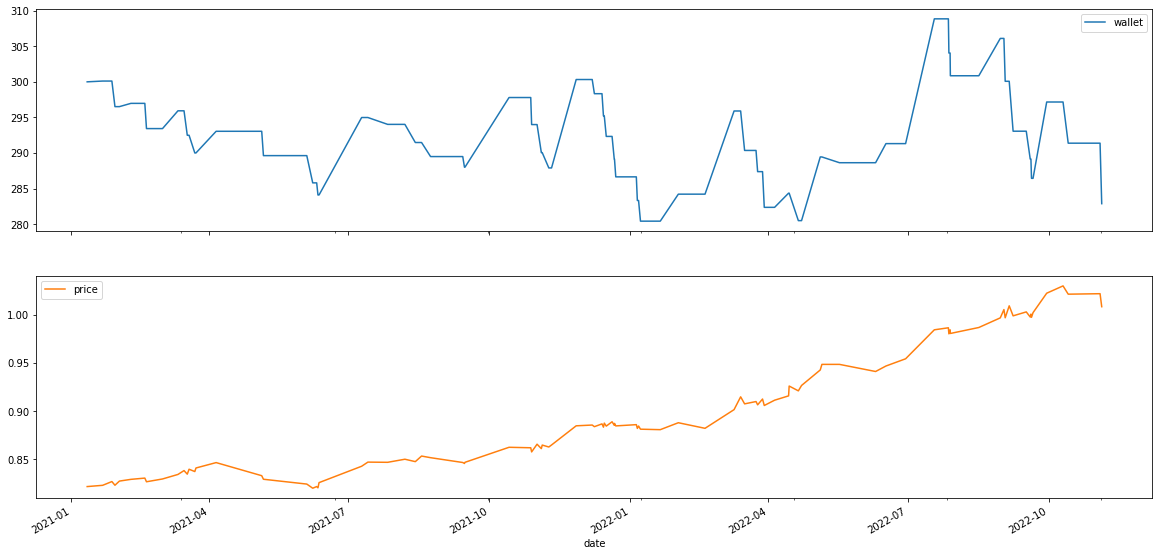

In [ ]:
dt[['wallet', 'price']].plot(subplots=True, figsize=(20, 10))
print("\n----- Plot -----")

In [ ]:
dt

,date,position,reason,price,frais,wallet,drawBack,resultat%,tradeIs
date,,,,,,,,,
2020-01-11 00:00:00,2020-01-11 00:00:00,Open Long,Open Long Market,143.5500,0.420000,300,0.000000,NaN,
2020-01-23 09:00:00,2020-01-23 09:00:00,LONG,Close Long Market,163.4800,0.535284,382.346032,0.000000,27.448677,Good
2020-01-27 10:00:00,2020-01-27 10:00:00,Open Long,Open Long Market,165.9400,0.535284,382.346032,0.000000,0.000000,
2020-02-17 04:00:00,2020-02-17 04:00:00,LONG,Close Long Market,245.6000,1.046998,747.855384,0.000000,95.596481,Good
2020-02-18 06:00:00,2020-02-18 06:00:00,Open Long,Open Long Market,267.1800,1.046998,747.855384,0.000000,0.000000,
...,...,...,...,...,...,...,...,...,...
2022-10-06 05:00:00,2022-10-06 05:00:00,Open Long,Open Long Market,1372.9700,16.978505,12127.503629,-0.145715,0.000000,
2022-10-07 12:00:00,2022-10-07 12:00:00,LONG,Stop Loss Long,1331.7809,15.913713,11366.938152,-0.199291,-6.271410,Bad
2022-10-18 07:00:00,2022-10-18 07:00:00,Open Long,Open Long Market,1336.7400,15.913713,11366.938152,-0.199291,0.000000,


In [ ]:
dt['MA20'] = dt['price'].rolling(20).mean() # 1440 minutes = 24 H = 1 Jour  !!!
dt['MA50'] = dt['price'].rolling(50).mean() # 1440 minutes = 24 H = 1 Jour  !!!
dt['MA150'] = dt['price'].rolling(150).mean() # 1440 minutes = 24 H = 1 Jour  !!!
dt['MA1400'] = dt['price'].rolling(1440).mean() # 1440 minutes = 24 H = 1 Jour  !!!

<AxesSubplot:xlabel='date'>

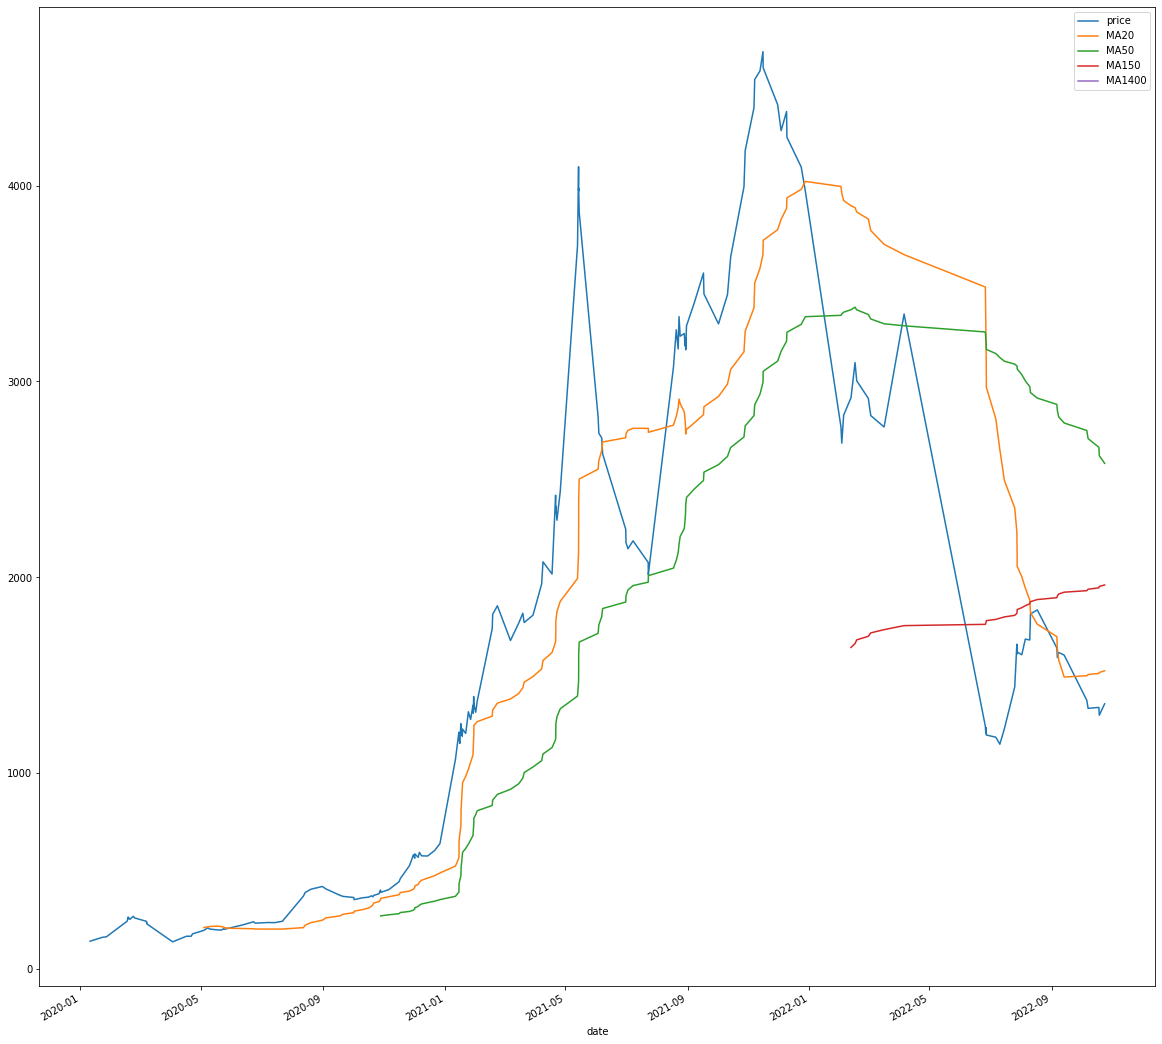

In [ ]:
#; df[['Close','MA20','MA50','MA150','MA1400','MA4K']]['2022-05-01':'2022-10-29'].plot(figsize=(20,20))
dt[['price','MA20','MA50','MA150','MA1400']].plot(figsize=(20,20))